In [286]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
import itertools

In [2]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 5.0 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/content/drive/MyDrive/Colab Notebooks/2023 휴먼이해 공모전/validation/smoteX_kcbert/kcbert_subset1_logit_test.pkl

### Loading NLP & Wav Logits

In [5]:
nlp_wav_logits = []
true_labels = []
for i in range(5):
  nlp_logit = pd.read_pickle(f'/content/drive/MyDrive/Colab Notebooks/2023 휴먼이해 공모전/ETRI_2023_AI_KCC/dataset/Fusion(text)/late/kcbert_subset{i+1}_logit_test.pkl')
  wav_logit = pd.read_pickle(f'/content/drive/MyDrive/Colab Notebooks/2023 휴먼이해 공모전/ETRI_2023_AI_KCC/dataset/Fusion(wav)/late/late{i+1}.pkl')

  for idx, row in nlp_logit.iterrows():
    if idx == 0:
      nlp_feature_array_train = nlp_logit.loc[idx, 'logit_value']
    else:
      new_array_train = nlp_logit.loc[idx, 'logit_value']
      nlp_feature_array_train = np.vstack([nlp_feature_array_train, new_array_train])
  nlp_train_df = pd.DataFrame(nlp_feature_array_train)

  for idx, row in wav_logit.iterrows():
    if idx == 0:
      wav_feature_array_train = wav_logit.loc[idx, 'logits']
    else:
      wav_new_array_train = wav_logit.loc[idx, 'logits']
      wav_feature_array_train = np.vstack([wav_feature_array_train, wav_new_array_train])
  wav_train_df = pd.DataFrame(wav_feature_array_train)

  nlp_wav_logits.append((nlp_train_df,wav_train_df))
  true_labels.append((nlp_logit['Emotion_x'], wav_logit['Emotion']))

In [14]:
nlp_wav_logits[0][0]

,0,1,2,3,4,5,6
0,0.010788,0.004384,0.719553,0.008526,0.009741,0.005013,0.241996
1,0.015114,0.014388,0.257702,0.020166,0.037385,0.001295,0.653950
2,0.379023,0.013638,0.399965,0.008043,0.021507,0.003232,0.174592
3,0.024273,0.013306,0.828237,0.039121,0.010829,0.004753,0.079480
4,0.047157,0.013190,0.788468,0.019085,0.016453,0.014676,0.100973
...,...,...,...,...,...,...,...
3055,0.014104,0.015191,0.014682,0.259793,0.434125,0.006823,0.255282
3056,0.003743,0.002124,0.003095,0.084102,0.860107,0.004893,0.041935
3057,0.006036,0.001729,0.003977,0.138130,0.824101,0.017307,0.008720
3058,0.003937,0.001211,0.005424,0.050407,0.920055,0.001788,0.017178


In [226]:
emotion_dict = {'angry': 0,
                'disgust': 1,
                'fear': 2,
                'happy': 3,
                'neutral': 4,
                'sad': 5,
                'surprise': 6}

In [267]:
nlp_probs = []
wav_probs = []
emotion_labels = []

for i in range(5):
  nlp_prob = nlp_wav_logits[i][0]
  nlp_prob = nlp_prob.to_numpy()
  wav_prob = nlp_wav_logits[i][1]
  wav_prob = wav_prob.to_numpy()
  emotion_label = true_labels[i][0]

  nlp_probs.append(nlp_prob)
  wav_probs.append(wav_prob)
  emotion_labels.append(emotion_label)

### Define optuna

In [228]:
import optuna

In [277]:
def objective(trial, nlp_probs, wav_probs, emotion_encoded):
    # 변수 정의
    w1 = trial.suggest_uniform('w1', 0, 1)
    w2 = 1 - w1

    # 가중합 계산
    p = w1 * nlp_probs + w2 * wav_probs

    # 분류 결과
    y_pred = np.argmax(p, axis=1)

    # F1-Score
    f1 = f1_score(y_pred, emotion_encoded, average='macro')

    # 정확도 계산
    accuracy = np.mean(y_pred == emotion_encoded)

    # 목적 함수값
    return -f1

In [230]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    #print(pred)
    pred = [id_to_emotion[num] for num in pred]
    print(y_test,pred)
    #one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.4f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.4f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.4f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.4f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

In [276]:
emotion_encoded_list = []

vec_func = np.vectorize(lambda x:emotion_dict[x])

for i in range(5):
  emotion_encoded = vec_func(emotion_labels[i])
  emotion_encoded_list.append(emotion_encoded)

id_to_emotion = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6:'surprise'}
id_to_emotion_func = np.vectorize(lambda x:id_to_emotion[x])

In [278]:
nlp_weights = []
wav_weights = []
y_preds = []

for i in range(5):
  study = optuna.create_study(direction='minimize')
  study.optimize(lambda trial: objective(trial, nlp_probs[i], wav_probs[i], emotion_encoded_list[i]), n_trials=300)

  nlp_weight = study.best_params['w1']
  wav_weight = 1 - nlp_weight

  print('==========Optimized weights==========')
  print(f'NLP : {nlp_weight}\nWav : {wav_weight}')

  nlp_weights.append(nlp_weight)
  wav_weights.append(wav_weight)

  probs = nlp_weight * nlp_probs[i] + wav_weight * wav_probs[i]
  y_pred_optuna = np.argmax(probs, axis=1)
  y_pred_optuna = id_to_emotion_func(y_pred_optuna)
  y_preds.append(y_pred_optuna)

[I 2023-04-30 13:06:24,291] A new study created in memory with name: no-name-c9d58b61-61bf-49b6-9746-ddf59b979c44
<ipython-input-277-b2d1ab080745>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  w1 = trial.suggest_uniform('w1', 0, 1)
[I 2023-04-30 13:06:24,308] Trial 0 finished with value: -0.5532581766669242 and parameters: {'w1': 0.0928693856599726}. Best is trial 0 with value: -0.5532581766669242.
<ipython-input-277-b2d1ab080745>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  w1 = trial.suggest_uniform('w1', 0, 1)
[I 2023-04-30 13:06:24,319] Trial 1 finished with value: -0.6246171386531942 and parameters: {'w1': 0.6080896543602186}. Best is tri

==========Optimized weights==========
NLP : 0.6624209728795479
Wav : 0.33757902712045207


[I 2023-04-30 13:06:30,883] Trial 16 finished with value: -0.6202955655251985 and parameters: {'w1': 0.45387209890883057}. Best is trial 11 with value: -0.6435253325437201.
<ipython-input-277-b2d1ab080745>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  w1 = trial.suggest_uniform('w1', 0, 1)
[I 2023-04-30 13:06:30,899] Trial 17 finished with value: -0.6371636940077494 and parameters: {'w1': 0.6333289945404379}. Best is trial 11 with value: -0.6435253325437201.
<ipython-input-277-b2d1ab080745>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  w1 = trial.suggest_uniform('w1', 0, 1)
[I 2023-04-30 13:06:30,915] Trial 18 finished with value: -0.6164510874

==========Optimized weights==========
NLP : 0.5845148686515476
Wav : 0.41548513134845244


[I 2023-04-30 13:06:36,382] Trial 18 finished with value: -0.6687242070421313 and parameters: {'w1': 0.5730067161216786}. Best is trial 18 with value: -0.6687242070421313.
<ipython-input-277-b2d1ab080745>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  w1 = trial.suggest_uniform('w1', 0, 1)
[I 2023-04-30 13:06:36,397] Trial 19 finished with value: -0.6506864507873147 and parameters: {'w1': 0.7431112606577025}. Best is trial 18 with value: -0.6687242070421313.
<ipython-input-277-b2d1ab080745>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  w1 = trial.suggest_uniform('w1', 0, 1)
[I 2023-04-30 13:06:36,411] Trial 20 finished with value: -0.63549583506

==========Optimized weights==========
NLP : 0.6235143953950725
Wav : 0.3764856046049275


[I 2023-04-30 13:06:41,981] Trial 15 finished with value: -0.6199127611869412 and parameters: {'w1': 0.46618150929366853}. Best is trial 6 with value: -0.620855280362543.
<ipython-input-277-b2d1ab080745>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  w1 = trial.suggest_uniform('w1', 0, 1)
[I 2023-04-30 13:06:41,999] Trial 16 finished with value: -0.584321306666026 and parameters: {'w1': 0.9987372360216792}. Best is trial 6 with value: -0.620855280362543.
<ipython-input-277-b2d1ab080745>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  w1 = trial.suggest_uniform('w1', 0, 1)
[I 2023-04-30 13:06:42,021] Trial 17 finished with value: -0.599851548113595

==========Optimized weights==========
NLP : 0.5016179872630033
Wav : 0.49838201273699667


<ipython-input-277-b2d1ab080745>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  w1 = trial.suggest_uniform('w1', 0, 1)
[I 2023-04-30 13:06:47,586] Trial 15 finished with value: -0.46406907245523704 and parameters: {'w1': 0.0034241754521158185}. Best is trial 2 with value: -0.47982974071382867.
<ipython-input-277-b2d1ab080745>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  w1 = trial.suggest_uniform('w1', 0, 1)
[I 2023-04-30 13:06:47,608] Trial 16 finished with value: -0.45669134771708536 and parameters: {'w1': 0.6308550205456069}. Best is trial 2 with value: -0.47982974071382867.
<ipython-input-277-b2d1ab080745>:3: FutureWarning: suggest_uniform 

==========Optimized weights==========
NLP : 0.46153086924174413
Wav : 0.5384691307582559


In [291]:
emo_keys = list(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])
f1_scores = []
confusion_matrix_list = []

for i in range(5):
  f1 = f1_score(emotion_labels[i], y_preds[i], average='micro')
  f1_scores.append(f1)

  cm = confusion_matrix(emotion_labels[i], y_preds[i])
  confusion_matrix_list.append(cm)

  print('Test Set F-score =  {0:.4f}'.format(f1))
  print('Test Set Precision =  {0:.4f}'.format(precision_score(emotion_labels[i], y_preds[i], average='macro')))
  print('Test Set Recall =  {0:.4f}'.format(recall_score(emotion_labels[i], y_preds[i], average='macro')))

Test Set F-score =  0.7369
Test Set Precision =  0.6025
Test Set Recall =  0.6742
Test Set F-score =  0.7980
Test Set Precision =  0.6914
Test Set Recall =  0.6291
Test Set F-score =  0.8137
Test Set Precision =  0.7656
Test Set Recall =  0.6252
Test Set F-score =  0.7872
Test Set Precision =  0.7290
Test Set Recall =  0.5772
Test Set F-score =  0.7565
Test Set Precision =  0.8394
Test Set Recall =  0.3949


In [294]:
confusion_matrix_mean = np.sum(np.array(confusion_matrix_list), axis=0) / 5

Confusion matrix, without normalization
[[1.8200e+02 3.8000e+00 3.4000e+00 3.0000e+00 9.3400e+01 4.6000e+00
  6.6000e+00]
 [1.4400e+01 1.9200e+01 2.2000e+00 1.2000e+00 3.8800e+01 4.0000e-01
  1.6000e+00]
 [5.2000e+00 6.0000e-01 4.7000e+01 2.0000e+00 1.3000e+01 1.2000e+00
  4.4000e+00]
 [5.8000e+00 1.4000e+00 1.8000e+00 1.5640e+02 1.6400e+02 1.6000e+00
  5.8000e+00]
 [5.6000e+01 1.5800e+01 6.8000e+00 5.1800e+01 1.7944e+03 1.7600e+01
  1.7600e+01]
 [3.6000e+00 2.0000e-01 2.0000e-01 6.0000e-01 4.0000e+01 9.1000e+01
  1.0000e+00]
 [8.6000e+00 1.2000e+00 7.2000e+00 8.2000e+00 6.0400e+01 8.0000e-01
  9.1800e+01]]


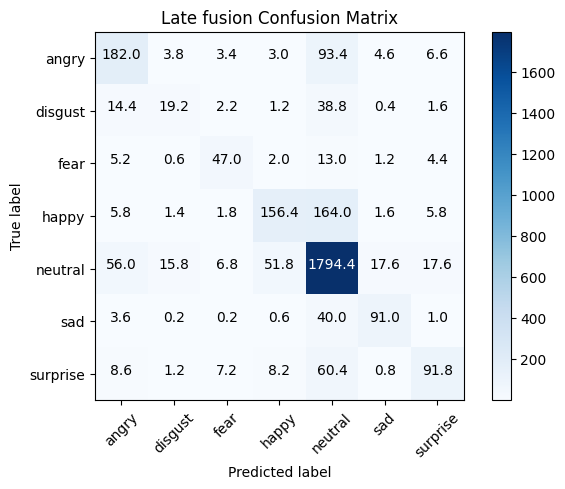

In [297]:
plot_confusion_matrix(confusion_matrix_mean, ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], title='Late fusion Confusion Matrix')

In [290]:
f1_scores = np.array(f1_scores)
final_f1_score = np.mean(f1_scores)
print(f'Final F1 score is {final_f1_score:.4f}')

Final F1 score is 0.7785


In [237]:
true_index_cv = []
false_index_cv = []

for i in range(5):
  true_index = []
  false_index = []
  for i in range(emotion_labels[i].shape[0]):
    if emotion_label[i] == y_pred_optuna[i]:
      true_index.append(i)
    else:
      false_index.append(i)
  true_index_cv.append(true_index)
  false_index_cv.append(false_index)

### Pi

In [ ]:
pi_values = []
for i in range(5):
  pi = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/2023 휴먼이해 공모전/ETRI_2023_AI_KCC/dataset/KFold/Subset{i+1}.csv')
  pi_value = pi['Emotion_p_i']
  pi_values.append(pi_value)

In [ ]:
pi_values[0]

0       0.488889
1       0.644444
2       0.355556
3       0.533333
4       0.488889
          ...   
3055    0.644444
3056    1.000000
3057    1.000000
3058    1.000000
3059    0.622222
Name: Emotion_p_i, Length: 3060, dtype: float64

In [ ]:
pi_true = []
pi_false = []

for i in range(5):
  result = pi_values[i].index.isin(true_index_cv[i])
  result_indexes = pi_values[i].index[result]
  filtered_values = pi_values[i].loc[result_indexes]
  filtered_values_false = pi_values[i].loc[~result]
  pi_true.extend(list(filtered_values))
  pi_false.extend(list(filtered_values_false))

### Late fusion의 커널밀도함수

In [248]:
import seaborn as sns

<ipython-input-264-c4ca2b7f7a59>:1: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.3`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=pi_true, label='Correct Classification', bw=0.3)
<ipython-input-264-c4ca2b7f7a59>:2: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.3`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=pi_false, label='Misclassification', bw=0.3)


Text(0.5, 0, 'P')

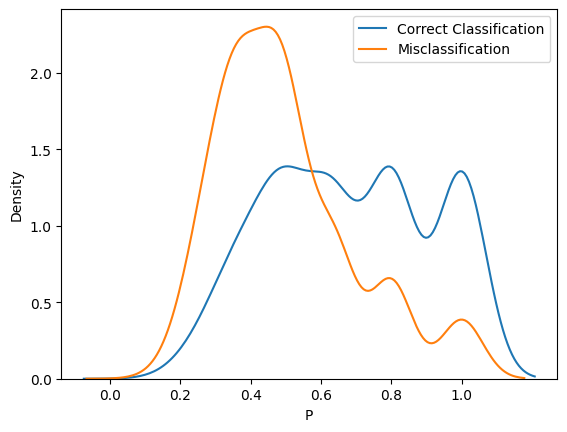

In [264]:
sns.kdeplot(data=pi_true, label='Correct Classification', bw=0.3)
sns.kdeplot(data=pi_false, label='Misclassification', bw=0.3)
plt.xticks([0.0,0.2,0.4,0.6,0.8,1.0])
plt.legend()
plt.xlabel('P')
# plt.title('정분류된 값의 KDE 분포')